We've seen how we can use a convolutional neural network to do some interesting things beyond classification.  In fact, there are many such examples.  For example, neural networks can be used to do both de-noising as well as in-painting.  The former is performed by training a network to map from a noise-corrupted version of a training data set to the non-corrupted version.  The latter is similar: remove sets of pixels from the input data set, and train a network to return the original picture. 

Along with the dequantization method we just saw, these are all generalizations of something called an autoencoder, which is simply a function (neural network, usually) which is trained to return the input as output.  Of course, it is trivial to create a neural network that can do this perfectly.  For example, if we have an input layer, followed by a hidden layer with linear activations, and the same number of nodes as the input, then we can just get the identity function.  

However, a much more interesting case comes when we impose a bottleneck: a hidden layer with substantially fewer nodes than the input.  This forces the neural network to come up with a compressed representation of the data.  For example, we can imagine taking the MNIST dataset, and generating a neural network with one input layer, three hidden layers, and one output layer.  Then, we'll set the number of nodes in that middle hidden layer to two. This will force the model to come up with a distillation of the 784-dimensional dataset into a 2-D representation, and will also force the training of neural network weights to re-constitute that encoding back into the full 784D representation.  Note that we've seen this kind of thing before in the form of PCA.  However, that relied on a linear transformation, namely the orthogonal rotation of the coordinate system.  A neural network is much more powerful because it can perform non-linear transformations.  Let's see what this can do for us.

First we'll import Keras along with the MNIST dataset.

In [1]:
import keras
import keras.models as km
import keras.layers as kl
import keras.losses as kloss
import keras.metrics as kmet
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

input_shape = (28**2,)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255
x_train = x_train.reshape((len(x_train),*input_shape))
x_test = x_test.reshape((len(x_test),*input_shape))

/home/brinkerhoff/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next, we can specify some parameters of the network architecture.  For the so-called latent dimension (the bottleneck), we'll use only two nodes, meaning that any representation of a handwritten digit will be a vector in $\mathbb{R}^2$.  For the hidden layers between, we'll use 128 nodes.

In [2]:
latent_dim = 2
intermediate_dim = 128

Next we'll specify our network architecture.  Because we'll want to re-use the weights of various layers in several models (namely functions from the input to the latent variables, from latent variables to outputs, and directly from input to output), I've structured this in such a way that we instantiate all the layers, then arrange them into the needed networks.

In [3]:
x = kl.Input(shape=input_shape)          # A placeholder for the input
z_in = kl.Input(shape=(latent_dim,))     # A placeholder for inputting latent variables

# Return a set of encoder layers
def get_encoder_layers():
    dense_1 = kl.Dense(intermediate_dim,activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001))
    latent_layer = kl.Dense(latent_dim,activation='linear')

    return [dense_1,latent_layer]

# Take the encoder layers and the input layer, and return the encoder portion of the autoencoder
def generate_encoder(x,encoder_layers):
    dense_1,latent_layer = encoder_layers
    d1 = dense_1(x)
    z = latent_layer(d1)
    return z

# Return a set of decoder layers
def get_decoder_layers():
    dense_2 = kl.Dense(intermediate_dim,activation='relu')
    reconstructed = kl.Dense(input_shape[0],activation='sigmoid')
    return [dense_2,reconstructed]

# Take the decoder layers and the latent values, and return the decoder
def generate_decoder(z,decoder_layers):
    dense_2,reconstructed = decoder_layers
    d2 = dense_2(z)
    x_rec = reconstructed(d2)
    return x_rec

# Instantiate the encoder layers
encoder_layers = get_encoder_layers()

# Define the mapping from input x to latent variable z
z = generate_encoder(x,encoder_layers)

# Wrap this mapping into a keras model
encoder = km.Model(x,z)


# Instantiate the decoder layers
decoder_layers = get_decoder_layers()

# Define the mapping from z (defined above) to x 
x_reconstructed = generate_decoder(z,decoder_layers)
# Define the mapping from some other z (user specified) to x
x_decoded = generate_decoder(z_in,decoder_layers)

# Generate a decoder model
decoder = km.Model(z_in,x_decoded)

# Generate the autoencoder model
vae = km.Model(x,x_reconstructed)

# Compile the model with a loss function
vae.compile(optimizer=keras.optimizers.adam(),loss=keras.losses.mean_squared_logarithmic_error)
vae.summary()

# Train
batch_size = 256
epochs=24
history = vae.fit(x_train, x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, x_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               101136    
Total params: 202,258
Trainable params: 202,258
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/24
60000/60000 [==============================] - 4s 66us/step - loss: 0.0452 

This takes a minute to train, but once its done, we can look at the filters that we produce, just like we did with PCA (and with classifying MLPs)

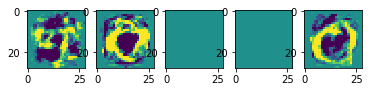

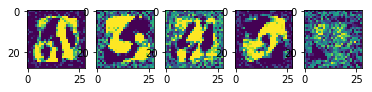

In [6]:
# Encoder weights (Good features to extract)
fig,axs = plt.subplots(nrows=1,ncols=5)
for i,ax in enumerate(axs):    
    i = np.random.randint(intermediate_dim)
    ax.imshow(encoder.get_weights()[0][:,i].reshape((28,28)),vmin=-0.005,vmax=0.005)
    
# Decoder weights (Good features to sum in order to reconstruct)
fig,axs = plt.subplots(nrows=1,ncols=5)
for i,ax in enumerate(axs):
    
    i = np.random.randint(intermediate_dim)
    
    ax.imshow(decoder.get_weights()[-2][i,:].reshape((28,28)),vmin=-0.1,vmax=0.1)
    
plt.show()

We can also look at how effective our autoencoder is: how well do we map back to the inputs.

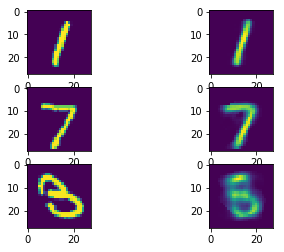

In [10]:
x_pred = vae.predict(x_test)

fig,axs = plt.subplots(nrows=3,ncols=2)
for j in range(3):
    ax = axs[j]
    i = np.random.randint(100)

    ax[0].imshow(x_test[i].reshape((28,28)))
    ax[1].imshow(x_pred[i].reshape((28,28)))
plt.show()

It does just OK.  But we are trying to distill all the variability in the MNIST dataset down into two numbers.  Let's look at those two numbers:

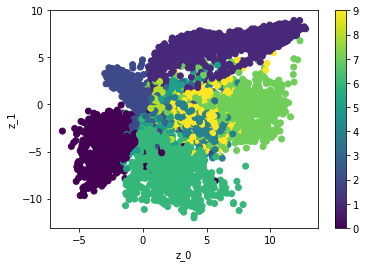

In [11]:
z_intermediate = encoder.predict(x_test)
plt.scatter(z_intermediate[:,0],z_intermediate[:,1],c=y_test)
plt.colorbar()
plt.xlabel('z_0')
plt.ylabel('z_1')
plt.show()

The dots are colored by digit.  There are clear distinctions between groups, but still quite a bit of overlap.  Nonetheless, we could make a pretty good classifier out of this (in fact this is what we're doing with an MLP).  

We can also pick values of our latent variables, and generate a new digit using it, which is pretty neat.

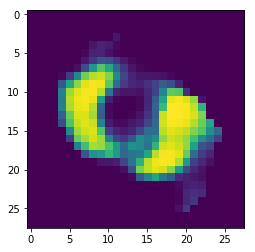

In [18]:
z = np.array([[10,-10]])
x_pred = decoder.predict(z).reshape((28,28))
plt.imshow(x_pred)
plt.show()


Unfortunately, it's easy to get off the map.  If we wanted to randomly generate handwritten digits by sampling $z$, we'd have a hard time, because the distribution of z values doesn't follow anything specific.  This problem becomes especially acute in high latent-dimension (if the plot were 16D); there would be a very large separation between each of the classes, thus although sevens and ones should be "close" to each other, in high latent space, they tend not to be.

How can we deal with this problem?  As it turns out, we can turn out autoencoder into something called a variational auto-encoder.  What we will do is that we will model our latent variable values as being normally distributed.  In essence, what we will try to do is to collapse our latent space into the little ball around the origin that defines a multi-dimensional Gaussian.  This takes a little bit of adaptation in our neural network. 

Our import statements as before:

In [19]:
import keras
import keras.models as km
import keras.layers as kl
import keras.losses as kloss
import keras.metrics as kmet
from keras import backend as K
from keras.datasets import mnist
import numpy as np

input_shape = (28**2,)
latent_dim = 2
intermediate_dim = 512

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255
x_train = x_train.reshape((len(x_train),*input_shape))
x_test = x_test.reshape((len(x_test),*input_shape))

Now, we'll define a special layer called *sampling*.  What this will do is take the output of our encoder and treat this output as the mean and the variance of a normal distribution, from which it will sample to produce our prediction of the latent variable $z$.  Thus our model has become stochastic!

In [ ]:
# sampling layer from latent distribution
def sampling(args):
    epsilon_std = 1
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

Now, in defining our model, we will add this sampling layer to the encoder.

In [ ]:
x = kl.Input(shape=input_shape)
z_in = kl.Input(shape=(latent_dim,))

def get_encoder_layers():
    dense_1 = kl.Dense(intermediate_dim,activation='relu')
    z_mean = kl.Dense(latent_dim)
    z_log_var = kl.Dense(latent_dim)
    latent_layer = kl.Lambda(sampling)   # Here's where we call the sampling layer
    return [dense_1,z_mean,z_log_var,latent_layer]
    
# Generate the encoding layer
def generate_encoder(x,encoder_layers):
    dense_1,z_mean,z_log_var,latent_layer = encoder_layers
    d1 = dense_1(x)
    zm = z_mean(d1)
    zv = z_log_var(d1)
    z = latent_layer([zm,zv])
    return z,zm,zv

# These stay the same
def get_decoder_layers():
    dense_2 = kl.Dense(intermediate_dim,activation='relu')
    reconstructed = kl.Dense(input_shape[0],activation='sigmoid')
    return [dense_2,reconstructed]

def generate_decoder(z,decoder_layers):
    dense_2,reconstructed = decoder_layers
    d2 = dense_2(z)
    x_rec = reconstructed(d2)
    return x_rec

encoder_layers = get_encoder_layers()
z,z_mean,z_log_var = generate_encoder(x,encoder_layers)

decoder_layers = get_decoder_layers()
x_reconstructed = generate_decoder(z,decoder_layers)
x_decoded = generate_decoder(z_in,decoder_layers)

We're almost there, but as it stands, all we're doing right now is injecting some randomness into our model: our latent variables have no motivation to be close to that unit-normal ball.  To provide that motivation, we'll add an extra term to our loss function that forces the distribution of latent variables to be close to a unit normal.  This extra loss function is called the Kullbach-Leibler divergence (or KL), and it effectively measures the difference between two probability distributions (if they're equal then the KL is zero).  For a unit normal distribution, the KL is:
$$
KL_{unit} = \frac{1}{2} \sum_{i=1}^m 1 + \log{\sigma_i^2} - \mu_i^2 - \sigma_i^2
$$
We'll add this to our normal loss function, weighted by a parameter $\gamma$.  The choice of symbol is deliberate: this effectively regularizes our autoencoder, but in such a way that the latent variables become normally distributed.  

In [ ]:
# Custom loss layer
class CustomVariationalLayer(kl.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = keras.metrics.binary_crossentropy(x, x_decoded_mean)
        gamma = 0.001
        kl_loss = - gamma * 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x_decoded
    


Now we can fully specify our model, compile, and fit

In [ ]:
y = CustomVariationalLayer()([x, x_reconstructed,z_mean,z_log_var])

encoder = km.Model(x,z)
decoder = km.Model(z_in,x_decoded)
vae = km.Model(x,y)

vae.compile(optimizer=keras.optimizers.adam())
vae.summary()

batch_size = 256
epochs=24
history = vae.fit(x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, None))

Now, let's look at our latent variable values:

In [ ]:
z_intermediate = encoder.predict(x_test)
plt.scatter(z_intermediate[:,0],z_intermediate[:,1],c=y_test,alpha=0.8)
plt.colorbar()
plt.show()

All of our latent variables fall more or less on a 2D unit normal.  Because of this, there is smooth variability between our data points, and this smoothness will extend to higher dimensions (which we'll see in a moment).  But let's see what sort of digits we get by smoothly varying our latent variables then decoding them.

In [ ]:
# Number of samples per dimension
n = 21

# Sample between z=-2,2
z_0 = np.linspace(-2,2,n)
z_1 = np.linspace(-2,2,n)

img_size = 28

figure = np.zeros((img_size * n, img_size * n, 1))
z_rest = [np.random.randn() for i in range(14)]

for i,z0 in enumerate(z_0):
    for j,z1 in enumerate(z_1):
        z_sample = np.array([[z0,z1]])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size,1)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size,:] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure.squeeze(),cmap=plt.cm.gray)
plt.show()


We're pretty limited of course because of our choice of only two latent variables.  What about three?

In [ ]:
import keras
import keras.models as km
import keras.layers as kl
import keras.losses as kloss
import keras.metrics as kmet
from keras import backend as K
from keras.datasets import mnist
import numpy as np

input_shape = (28**2,)
latent_dim = 3
intermediate_dim = 512

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255
x_train = x_train.reshape((len(x_train),*input_shape))
x_test = x_test.reshape((len(x_test),*input_shape))

x = kl.Input(shape=input_shape)
z_in = kl.Input(shape=(latent_dim,))

# sampling layer from latent distribution
def sampling(args):
    epsilon_std = 1
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def get_encoder_layers():
    dense_1 = kl.Dense(intermediate_dim,activation='relu')
    z_mean = kl.Dense(latent_dim)
    z_log_var = kl.Dense(latent_dim)
    latent_layer = kl.Lambda(sampling)
    return [dense_1,z_mean,z_log_var,latent_layer]
    

def generate_encoder(x,encoder_layers):
    dense_1,z_mean,z_log_var,latent_layer = encoder_layers
    d1 = dense_1(x)
    zm = z_mean(d1)
    zv = z_log_var(d1)
    z = latent_layer([zm,zv])
    return z,zm,zv

def get_decoder_layers():
    dense_2 = kl.Dense(intermediate_dim,activation='relu')
    reconstructed = kl.Dense(input_shape[0],activation='sigmoid')
    return [dense_2,reconstructed]

def generate_decoder(z,decoder_layers):
    dense_2,reconstructed = decoder_layers
    d2 = dense_2(z)
    x_rec = reconstructed(d2)
    return x_rec

encoder_layers = get_encoder_layers()
z,z_mean,z_log_var = generate_encoder(x,encoder_layers)

decoder_layers = get_decoder_layers()
x_reconstructed = generate_decoder(z,decoder_layers)
x_decoded = generate_decoder(z_in,decoder_layers)

# Custom loss layer
class CustomVariationalLayer(kl.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = keras.metrics.binary_crossentropy(x, x_decoded_mean)
        beta = 0.001
        kl_loss = - beta * 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x_decoded
    
y = CustomVariationalLayer()([x, x_reconstructed,z_mean,z_log_var])

encoder = km.Model(x,z)
decoder = km.Model(z_in,x_decoded)
vae = km.Model(x,y)

vae.compile(optimizer=keras.optimizers.adam())
vae.summary()

batch_size = 256
epochs=24
history = vae.fit(x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, None))


We can plot the resulting points in 3D.  

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
z_intermediate = encoder.predict(x_test)
fig = plt.figure()
fig.set_size_inches(10,10)
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(z_intermediate[:,0],z_intermediate[:,1],z_intermediate[:,2],c=y_test,alpha=0.8)
fig.colorbar(p)
plt.show()

There's better separation in 3D, which we can see when we perform reconstructions of our test images

In [ ]:
x_pred = vae.predict(x_test)

fig,axs = plt.subplots(nrows=3,ncols=2)
for j in range(3):
    ax = axs[j]
    i = np.random.randint(100)

    ax[0].imshow(x_test[i].reshape((28,28)))
    ax[1].imshow(x_pred[i].reshape((28,28)))
plt.show()

Let's make the same array of digits, smoothly varying the first two latent dimensions, while holding the third one fixed.

In [ ]:

n = 21

z_0 = np.linspace(-2,2,n)
z_1 = np.linspace(-2,2,n)

img_size = 28

figure = np.zeros((img_size * n, img_size * n, 1))
z_rest = [np.random.randn() for i in range(14)]

for i,z0 in enumerate(z_0):
    for j,z1 in enumerate(z_1):
        z_sample = np.array([[z0,z1,0.0]])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size,1)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size,:] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure.squeeze(),cmap=plt.cm.gray)
plt.show()

In [ ]:
import keras
import keras.models as km
import keras.layers as kl
import keras.losses as kloss
import keras.metrics as kmet
from keras import backend as K
from keras.datasets import mnist
import numpy as np

input_shape = (28**2,)
latent_dim = 12
intermediate_dim = 512

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255
x_train = x_train.reshape((len(x_train),*input_shape))
x_test = x_test.reshape((len(x_test),*input_shape))

x = kl.Input(shape=input_shape)
z_in = kl.Input(shape=(latent_dim,))

# sampling layer from latent distribution
def sampling(args):
    epsilon_std = 1
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def get_encoder_layers():
    dense_1 = kl.Dense(intermediate_dim,activation='relu')
    z_mean = kl.Dense(latent_dim)
    z_log_var = kl.Dense(latent_dim)
    latent_layer = kl.Lambda(sampling)
    return [dense_1,z_mean,z_log_var,latent_layer]
    

def generate_encoder(x,encoder_layers):
    dense_1,z_mean,z_log_var,latent_layer = encoder_layers
    d1 = dense_1(x)
    zm = z_mean(d1)
    zv = z_log_var(d1)
    z = latent_layer([zm,zv])
    return z,zm,zv

def get_decoder_layers():
    dense_2 = kl.Dense(intermediate_dim,activation='relu')
    reconstructed = kl.Dense(input_shape[0],activation='sigmoid')
    return [dense_2,reconstructed]

def generate_decoder(z,decoder_layers):
    dense_2,reconstructed = decoder_layers
    d2 = dense_2(z)
    x_rec = reconstructed(d2)
    return x_rec

encoder_layers = get_encoder_layers()
z,z_mean,z_log_var = generate_encoder(x,encoder_layers)

decoder_layers = get_decoder_layers()
x_reconstructed = generate_decoder(z,decoder_layers)
x_decoded = generate_decoder(z_in,decoder_layers)

# Custom loss layer
class CustomVariationalLayer(kl.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = keras.metrics.binary_crossentropy(x, x_decoded_mean)
        beta = 0.001
        kl_loss = - beta * 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x_decoded
    
y = CustomVariationalLayer()([x, x_reconstructed,z_mean,z_log_var])

encoder = km.Model(x,z)
decoder = km.Model(z_in,x_decoded)
vae = km.Model(x,y)

vae.compile(optimizer=keras.optimizers.adam())
vae.summary()

batch_size = 256
epochs=24
history = vae.fit(x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, None))


In [ ]:
x_pred = vae.predict(x_test)

fig,axs = plt.subplots(nrows=3,ncols=2)
for j in range(3):
    ax = axs[j]
    i = np.random.randint(100)

    ax[0].imshow(x_test[i].reshape((28,28)))
    ax[1].imshow(x_pred[i].reshape((28,28)))
plt.show()

In [ ]:
n = 21

z_0 = np.linspace(-2,2,n)
z_1 = np.linspace(-2,2,n)

img_size = 28

figure = np.zeros((img_size * n, img_size * n, 1))
z_rest = [np.random.randn() for i in range(14)]

for i,z0 in enumerate(z_0):
    for j,z1 in enumerate(z_1):
        z_sample = np.array([[z0,z1]+[np.random.randn() for q in range(10)]])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size,1)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size,:] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure.squeeze(),cmap=plt.cm.gray)
plt.show()

Finally, these things don't need to apply only to digits.  One of the cool applications of variational autoencoders is computer-generated images.  For this, we'll utilize the CIFAR-10 dataset, which has elements that sort of look like: 

In [ ]:
import keras
import keras.models as km
import keras.layers as kl
import keras.losses as kloss
import keras.metrics as kmet
from keras import backend as K
import numpy as np

import pickle

from keras.datasets import cifar10,mnist


input_shape = ((32,32,3))

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255
x_test = x_test/255
x_train = x_train.reshape((len(x_train),*input_shape))
x_test = x_test.reshape((len(x_test),*input_shape))

fig,axs = plt.subplots(nrows=1,ncols=5)
for ax in axs:
    ax.imshow((x_test[np.random.randint(100)]*255).astype(int))
plt.show()

We can build a similar autoencoder, but this time we'll encode and decode using a convolutional neural network.

In [ ]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#input_shape = ((28,28,1))
img_rows,img_cols,bands = input_shape
latent_dim = 16
filters = 32
intermediate_dim = 128
num_conv = 3  

x = kl.Input(shape=input_shape)

def get_encoder_layers():
    conv_1 = kl.Conv2D(3,kernel_size=(3,3),padding='same',activation='relu')
    conv_2 = kl.Conv2D(filters,kernel_size=(3,3),padding='same',activation='relu',strides=(2,2))
    conv_3 = kl.Conv2D(filters,kernel_size=num_conv,padding='same',activation='relu',strides=1)
    conv_4 = kl.Conv2D(filters,kernel_size=num_conv,activation='relu',strides=1)

    flat = kl.Flatten()
    hidden = kl.Dense(intermediate_dim,activation='relu')

    z_mean = kl.Dense(latent_dim,name='z_mean')
    z_log_var = kl.Dense(latent_dim,name='z_log_var')

    z = kl.Lambda(sampling,output_shape=(latent_dim,),name='z')
    
    return [conv_1,conv_2,conv_3,conv_4,flat,hidden,z_mean,z_log_var,z]

def generate_encoder(x,encoder_layers):
    conv_1,conv_2,conv_3,conv_4,flat,hidden,z_mean,z_log_var,z = encoder_layers
    c1 = conv_1(x)
    c2 = conv_2(c1)
    c3 = conv_3(c2)
    c4 = conv_4(c3)
    f = flat(c4)
    h = hidden(f)
    zm = z_mean(h)
    zv = z_log_var(h)
    zz = z([zm,zv])
    return zz,zm,zv
    
l = get_encoder_layers()
z,z_mean,z_log_var = generate_encoder(x,l)

# Decoder architecture
def get_decoder_layers():
    decoder_hid = kl.Dense(intermediate_dim,activation='relu')
    decoder_upsample = kl.Dense(filters*img_rows//2*img_cols//2,name='up_dense_1',activation='relu')

    decoder_reshape = kl.Reshape((img_rows//2,img_cols//2,filters),name='reshape_1')
    deconv_1 = kl.Conv2DTranspose(filters,kernel_size=num_conv,padding='same',activation='relu')
    deconv_2 = kl.Conv2DTranspose(filters,kernel_size=num_conv,padding='same',activation='relu')
    deconv_3 = kl.Conv2DTranspose(filters,kernel_size=(3,3),strides=(2,2),padding='valid',activation='relu')
    x_decoded = kl.Conv2D(input_shape[-1],kernel_size=2,padding='valid',activation='sigmoid')
    return [decoder_hid,decoder_upsample,decoder_reshape,deconv_1,deconv_2,deconv_3,x_decoded]

def generate_decoder(z,decoder_layers):
    decoder_hid,decoder_upsample,decoder_reshape,deconv_1,deconv_2,deconv_3,x_decoded = decoder_layers
    dh = decoder_hid(z)
    du = decoder_upsample(dh)
    rs = decoder_reshape(du)
    d1 = deconv_1(rs)
    d2 = deconv_2(d1)
    d3 = deconv_3(d2)
    xd = x_decoded(d3)
    return xd

ld = get_decoder_layers()
x_decoded = generate_decoder(z,ld)

z_in = kl.Input(shape=(latent_dim,))
x_gen = generate_decoder(z_in,ld)
encoder = km.Model(x,z)
decoder = km.Model(z_in,x_gen)

# Custom loss layer
class CustomVariationalLayer(kl.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded,z_mean,z_log_var):
        beta = 1e-3
        x = K.flatten(x)
        x_decoded = K.flatten(x_decoded)
        xent_loss = kmet.binary_crossentropy(x, x_decoded)
        kl_loss = - 0.5 * beta * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        z_mean = inputs[2]
        z_log_var = inputs[3]

        loss = self.vae_loss(x, x_decoded,z_mean,z_log_var)
        self.add_loss(loss, inputs=inputs)
        return x_decoded

y = CustomVariationalLayer()([x, x_decoded,z_mean,z_log_var])



# entire model
vae = km.Model(x, y)
#vae.compile(optimizer='adam', loss=None)
#vae.summary()

batch_size = 256
epochs = 300
# train the autoencoder
#history = vae.fit(x_train,
#        epochs=epochs,
#        batch_size=batch_size,
#        validation_data=(x_test, None))    



This one takes too long to train, so we'll load the weights I precomputed overnight.

In [ ]:
encoder = km.load_model('encoder.h5')
decoder = km.load_model('decoder.h5')

Now we can sample from the latent space (a 16-vector for this model), and generate strange new computer-generated images (the dreams of robots).  

In [ ]:
import matplotlib.pyplot as plt
n = 5
z_0 = np.linspace(-3,3,n)
z_1 = np.linspace(-3,3,n)

img_size = 32

figure = np.zeros((img_size * n, img_size * n, 3))
z_rest = [np.random.randn() for i in range(14)]

for i,z0 in enumerate(z_0):
    for j,z1 in enumerate(z_1):
        z_sample = np.array([[z0,z1]+z_rest])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size,3)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size,:] = img

figure*=255
figure = figure.astype(int)

plt.figure(figsize=(8, 8))
plt.imshow(figure.squeeze())
plt.show()